In [3]:
import csv
import math

import matplotlib.pyplot as plt
import numpy as np

from keras import applications
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D
from keras.initializers import glorot_uniform
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [8]:
# read the CSV into memory
prices = []
image_paths = []

data_path = "../datasets/bikes_im/"
with open("../datasets/bikes_filtered.csv") as file:
    reader = csv.reader(file)
    i = -1
    for row in reader:
        i += 1
        index = row[0]
        name = row[1]
        msrp = row[2]
        
        image_path = data_path + index + '.jpg'
        image_paths.append(image_path)
        prices.append(int(msrp))

train_indices = np.load("bikes_train_indices.npy")
test_indices = np.load("bikes_test_indices.npy")
print(train_indices.shape)
print(test_indices.shape)

(19658,)
(2185,)


In [6]:
def image_generator(indices, batch_size):

    num_batches = int(len(indices) / batch_size)
    
    while True:
        for batch_i in range(num_batches):
            if batch_i == num_batches - 1:
                # special case: return as many as possible
                start_i = batch_i * batch_size
                batch_indices = indices[start_i:]
                
                X = np.zeros((len(batch_indices), 224, 224, 3))
                Y = np.zeros((len(batch_indices), 1))
            
            else:
                start_i = batch_i * batch_size
                end_i = start_i + batch_size

                batch_indices = indices[start_i:end_i]

                X = np.zeros((batch_size, 224, 224, 3))
                Y = np.zeros((batch_size, 1))
            
            for i, index in enumerate(batch_indices):
                img = image.load_img(image_paths[index], target_size=(224, 224))
                X[i, :, :, :] = image.img_to_array(img)                
                Y[i] = prices[index]
            
            # use vgg16 preprocessing
            X = preprocess_input(X)
            
            yield (X, Y)

In [14]:
# Hyperparameters

num_settings = 1

hp_dropout = [0.25] * num_settings

#RMSprop
hp_lr = [0.0005] * num_settings
hp_rho = [0.9] * num_settings
hp_epsilon = [1e-07] * num_settings
hp_decay = [0.0] * num_settings

# Number of hidden units
hp_hidden = [300] * num_settings

# Minibatch size
hp_mbsize = [64] * num_settings
minibatch_size = hp_mbsize[0]

train_steps = math.ceil(len(train_indices) / minibatch_size)
test_steps = math.ceil(len(test_indices) / minibatch_size)

num_epochs = 30

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=308, epochs=30, validation_data=<generator..., callbacks=[<keras.ca..., validation_steps=35)`


Epoch 1/30
308/308 [==============================] - 128s - loss: 3186191.6300 - val_loss: 2113432.3245
Epoch 2/30
308/308 [==============================] - 128s - loss: 1735787.3688 - val_loss: 1225687.8430
Epoch 3/30
308/308 [==============================] - 128s - loss: 1401198.7435 - val_loss: 1292399.7431
Epoch 4/30
308/308 [==============================] - 128s - loss: 1190548.2884 - val_loss: 1114816.4735
Epoch 5/30
308/308 [==============================] - 128s - loss: 1026312.9905 - val_loss: 896751.8644
Epoch 6/30
308/308 [==============================] - 128s - loss: 897661.1175 - val_loss: 863635.1773
Epoch 7/30
308/308 [==============================] - 128s - loss: 804581.2450 - val_loss: 849282.9828
Epoch 8/30
308/308 [==============================] - 128s - loss: 730848.2145 - val_loss: 891318.1822
Epoch 9/30
308/308 [==============================] - 128s - loss: 685937.2692 - val_loss: 676409.6352
Epoch 10/30
308/308 [==============================] - 128s - lo

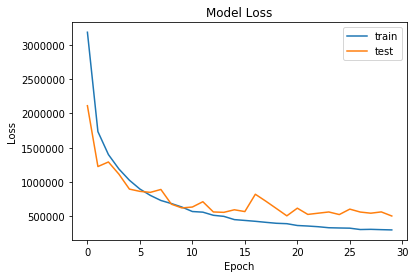

In [ ]:
# store the results of each setting
train_losses = np.zeros(num_settings)
dev_losses = np.zeros(num_settings)

for setting in range(num_settings):

    img_input = Input(shape=(224, 224, 3))

    # block 1
    x = Conv2D(32, (5, 5), activation='relu', padding='same', kernel_initializer='glorot_uniform', name='conv1')(img_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    # block 2
    x = Dropout(hp_dropout[setting])(x)
    x = Conv2D(64, (5, 5), activation='relu', padding='same', kernel_initializer='glorot_uniform', name='conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    # block 3
    x = Dropout(hp_dropout[setting])(x)
    x = Conv2D(64, (5, 5), activation='relu', padding='same', kernel_initializer='glorot_uniform', name='conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

    # block 4
    x = Dropout(hp_dropout[setting])(x)
    x = Conv2D(128, (5, 5), activation='relu', padding='same', kernel_initializer='glorot_uniform', name='conv4')(x)
    x = MaxPooling2D((4, 4), strides=(4, 4), name='pool4')(x)

    x = Flatten(name='flatten')(x)
    x = Dropout(hp_dropout[setting])(x)
    x = Dense(512, activation='relu', name='fc1', kernel_initializer='glorot_uniform')(x)
    x = Dense(1, activation='linear', name='output', kernel_initializer='glorot_uniform')(x)
    
    new_model = Model(img_input, x, name='new_network')
    
    # RMSprop optimizer
    new_model.compile(loss='mean_squared_error',
                      optimizer=optimizers.RMSprop(
                              lr=hp_lr[setting], 
                              rho=hp_rho[setting], 
                              epsilon=hp_epsilon[setting], 
                              decay=hp_decay[setting]))
    
    checkpoint_path = '/output/new-network-best.hdf5'
    
    # keep a checkpoint
    checkpoint = ModelCheckpoint(checkpoint_path,
                                monitor='val_loss',
                                save_best_only=True,
                                mode='min')
    
    minibatch_size = hp_mbsize[setting]

    train_steps = math.ceil(len(train_indices) / minibatch_size)
    test_steps = math.ceil(len(test_indices) / minibatch_size)

    # fine-tune the model
    history = new_model.fit_generator(
        image_generator(train_indices, minibatch_size),
        steps_per_epoch=train_steps,
        epochs=num_epochs,
        validation_data=image_generator(test_indices, minibatch_size),
        nb_val_samples=test_steps,
        callbacks=[checkpoint])
    
    # store the training and dev losses for the last epoch (current model)
    train_losses[setting] = history.history['loss'][-1]
    dev_losses[setting] = history.history['val_loss'][-1]
    

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    print("==========")

In [4]:
# get predictions on each batch yielded the validation generator.

new_model = load_model('/output/new-network-best.hdf5')

In [15]:
validation_generator = image_generator(test_indices, minibatch_size)

predicted = []
actual = []

for step in range(test_steps):
    X, Y = next(validation_generator)
    curr_pred = new_model.predict(X)
    for entry in curr_pred:
        predicted.append(entry)
    for entry in Y:
        actual.append(entry)

In [16]:
predicted = np.array(predicted)
actual = np.array(actual)

MSE = mean_squared_error(predicted, actual)
MAE = mean_absolute_error(predicted, actual)
R2 = r2_score(actual, predicted)

print((MSE, MAE, R2))

(493212.59266836732, 380.20511987549617, 0.85070303862025931)
